# Simulation code of System\#2

<img src="FigureFolder/System2.png" width=800/>

This figure shows the overview of System\#2 (power network in Tennessee, USA).

With Python and Jupyter Notebook properly configured, you can directly run this notebook from start to finish.

In [1]:
import os
from Utils.Pyd.MonteCarlo_Utils import MonteCarlo_Naive_Sample, MonteCarlo_XULUO_Sample, \
    MonteCarlo_Past_Info_Sample, \
    MonteCarlo_Fatigue_Accumulation_Sample
from Utils.Pyd.Problem_Define import ProblemInstance
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
import pickle
from pypower.idx_bus import BUS_I

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["mathtext.default"] = "rm"

np.random.seed(613)
random.seed(613)

deltaT_name_list = {
    3 / 3600: r'$\Delta \it{t}=3\ \mathrm{s}$',
    1 / 60: r'$\Delta \it{t}=1\ \mathrm{min}$',
    0.1: r'$\Delta \it{t}=0.1\ \mathrm{h}$',
    1 / 12: r'$\Delta \it{t}=5\ \mathrm{min}$',
    0.2: r'$\Delta \it{t}=0.2\ \mathrm{h}$',
    0.25: r'$\Delta \it{t}=15\ \mathrm{min}$',
    0.5: r'$\Delta \it{t}=0.5\ \mathrm{h}$',
    1: r'$\Delta \it{t}=1\ \mathrm{h}$',
    2: r'$\Delta \it{t}=2\ \mathrm{h}$',
    3: r'$\Delta \it{t}=3\ \mathrm{h}$'
}

In [2]:
if os.path.exists("./Save_File/UIUC150.pkl"):
    with open("./Save_File/UIUC150.pkl", 'rb') as file:
        ins = pickle.loads(file.read())
else:
    ins = ProblemInstance(name="UIUC150")
# ------
# Parameters
BASE_DELTAT = ins.deltaT # The most fundamental time resolution of the system.
T = ins.end_time - ins.start_time
deltaT_list = [1/60, 1/12, 0.25, 1, 2, 3] # The time resolutions to be studied.
N_sim = 100 # Monte Carlo simulation number.

Successfully loaded PyPower case from ./DataFolder/UIUC150Case/uiuc_150bus.mat.
  Base MVA: 100
  Number of buses: 150
  Number of generators: 27
  Number of branches: 217
Generating wind speed curve for line [1 / 217]...
Generating wind speed curve for line [2 / 217]...
Generating wind speed curve for line [3 / 217]...
Generating wind speed curve for line [4 / 217]...
Generating wind speed curve for line [5 / 217]...
Generating wind speed curve for line [6 / 217]...
Generating wind speed curve for line [7 / 217]...
Generating wind speed curve for line [8 / 217]...
Generating wind speed curve for line [9 / 217]...
Generating wind speed curve for line [10 / 217]...
Generating wind speed curve for line [11 / 217]...
Generating wind speed curve for line [12 / 217]...
Generating wind speed curve for line [13 / 217]...
Generating wind speed curve for line [14 / 217]...
Generating wind speed curve for line [15 / 217]...
Generating wind speed curve for line [16 / 217]...
Generating wind speed

In [3]:
# Power Load Curve
L_total = np.zeros(ins.H)
for bus_index in range(ins.power_traffic_system['bus'].shape[0]):
    bus_num = ins.power_traffic_system['bus'][bus_index, BUS_I]
    L_total = L_total + ins.power_load_curve[bus_num][:]

In [4]:
# Generate high-resolution gust wind speed curves
w = np.zeros((ins.power_traffic_system['branch'].shape[0], ins.H))
for j in range(ins.power_traffic_system['branch'].shape[0]):
    for h in range(ins.H):
        w[j][h] = ins.hurricane_curve[j][h]

In [5]:
# Parameters of the cumulative fatigue damage theory.
a = 0 # By simply setting the cumulative fatigue value to 0, it can be degenerated to a mechanism that only considers damage caused by instantaneous intensity.
b = 0.0055
v0_mu = 20
v0_sigma = 1.2
vmax_mu = 53
vmax_sigma = 5.0
Dres_mu = 0.2
Dres_sigma = 0.05
v0 = np.random.normal(v0_mu, v0_sigma, size=ins.power_traffic_system['branch'].shape[0])
vmax = np.random.normal(vmax_mu, vmax_sigma, size=ins.power_traffic_system['branch'].shape[0])
Dres = np.random.normal(Dres_mu, Dres_sigma, size=ins.power_traffic_system['branch'].shape[0])

In [ ]:
# Fragility curve, described by a log-normal distribution
# See system1/Utils/experiment_fitting1.ipynb
mu = 3.97126543
sigma = 0.07535683

In [7]:
# Convert high-resolution data to low-resolution data
def downsample(data, deltaT, method):
    if deltaT <= BASE_DELTAT:
        return data
    """
    Convert high-resolution data to low-resolution data  
    :param data: High-resolution data  
    :param deltaT: Low-resolution time step (hours)  
    :return: Low-resolution data
    """
    n_samples = int(len(data) * BASE_DELTAT / deltaT)
    downsampled_data = np.zeros(n_samples)
    for i in range(n_samples):
        if method == "mean":
            downsampled_data[i] = np.mean(data[int(i * deltaT / BASE_DELTAT):int((i + 1) * deltaT / BASE_DELTAT)])
        else:
            raise ValueError("Invalid method")
    return downsampled_data

## (a)

Independent sampling directly based on the vulnerability curve

In [8]:
monte_carlo_naive_sample = []
for deltaT in deltaT_list:
    print(f">>>deltaT = {deltaT}")
    L_downsampled = np.zeros((ins.power_traffic_system['bus'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for bus_index in range(ins.power_traffic_system['bus'].shape[0]):
        bus_num = ins.power_traffic_system['bus'][bus_index, BUS_I]
        L_downsampled[bus_index, :] = downsample(ins.power_load_curve[bus_num][:], deltaT, 'mean')
    w_downsampled = np.zeros((ins.power_traffic_system['branch'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for j in range(ins.power_traffic_system['branch'].shape[0]):
        w_downsampled[j, :] = downsample(w[j][:], deltaT, 'mean')
    monte_carlo_naive_sample.append(MonteCarlo_Naive_Sample(ins, deltaT, N_sim,
                                                            L_downsampled, w_downsampled, 
                                                            fragility_params={'mu': mu, 'sigma': sigma}))

>>>deltaT = 0.016666666666666666
Simulation 1/100 (deltaT=0.016666666666666666)
Set parameter Username
Set parameter LicenseID to value 2585944
Academic license - for non-commercial use only - expires 2025-11-17
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 2/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 3/100 (deltaT=0.016666666666666666)
  

In [9]:
f_save = open("./SolutionFolder/MonteCarlo_Naive_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_naive_sample, f_save)
f_save.close()

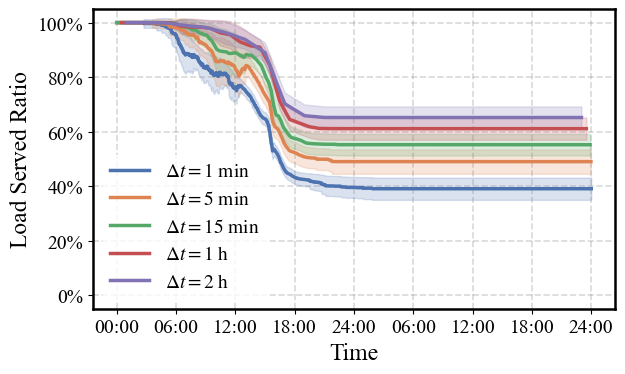

In [10]:
with open("./SolutionFolder/MonteCarlo_Naive_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_naive_sample = pickle.loads(file.read())
    monte_carlo_naive_sample = [monte_carlo_naive_sample[m]["all_load_served"] 
                                for m in range(len(deltaT_list))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)
colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M-1):
    t = np.arange(0, T, deltaT_list[m]) + deltaT_list[m] / 2
    L_total_downsampled = downsample(L_total, deltaT_list[m], 'mean')
    color = colors[m]
    load_served_ratio = monte_carlo_naive_sample[m] / L_total_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.5),
        label=deltaT_name_list[deltaT_list[m]],
        color=colors[m],
        linewidth=2.5
    )
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.01, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
plt.ylim(0-0.05, 1.05)
plt.legend(loc='best',
           prop={'family': 'times new roman', 'size': 14},
           edgecolor='1.0',
           framealpha=0.8
)
ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)
plt.tight_layout()
plt.show()

## (b)

Method based on fixed component resilience attributes (in [8])

In [11]:
monte_carlo_XULUO_sample = []
for deltaT in deltaT_list:
    print(f">>>deltaT = {deltaT}")
    L_downsampled = np.zeros((ins.power_traffic_system['bus'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for bus_index in range(ins.power_traffic_system['bus'].shape[0]):
        bus_num = ins.power_traffic_system['bus'][bus_index, BUS_I]
        L_downsampled[bus_index, :] = downsample(ins.power_load_curve[bus_num][:], deltaT, 'mean')
    w_downsampled = np.zeros((ins.power_traffic_system['branch'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for j in range(ins.power_traffic_system['branch'].shape[0]):
        w_downsampled[j, :] = downsample(w[j][:], deltaT, 'mean')
    monte_carlo_XULUO_sample.append(MonteCarlo_XULUO_Sample(ins, deltaT, N_sim,
                                                            L_downsampled, w_downsampled, 
                                                            fragility_params={'mu': mu, 'sigma': sigma}))

>>>deltaT = 0.016666666666666666
Simulation 1/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 2/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 3/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time ste

In [12]:
f_save = open("./SolutionFolder/MonteCarlo_XULUO_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_XULUO_sample, f_save)
f_save.close()

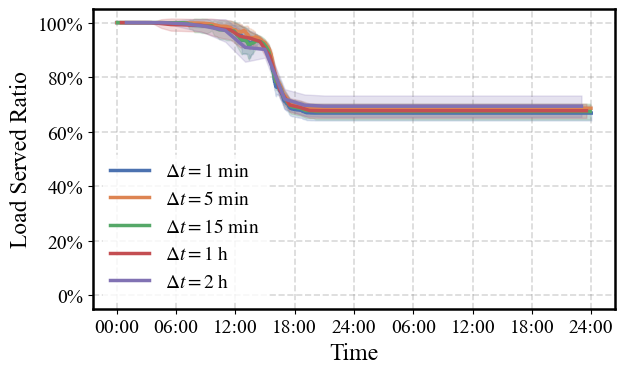

In [13]:
with open("./SolutionFolder/MonteCarlo_XULUO_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_XULUO_sample = pickle.loads(file.read())
    monte_carlo_XULUO_sample = [monte_carlo_XULUO_sample[m]["all_load_served"] 
                                for m in range(len(deltaT_list))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)
colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M-1):
    t = np.arange(0, T, deltaT_list[m]) + deltaT_list[m] / 2
    L_total_downsampled = downsample(L_total, deltaT_list[m], 'mean')
    color = colors[m]

    load_served_ratio = monte_carlo_XULUO_sample[m] / L_total_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.5),
        label=deltaT_name_list[deltaT_list[m]],
        color=colors[m],
        linewidth=2.5,
    )
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.01, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
plt.ylim(0-0.05, 1.05)
plt.legend(loc='best',
           prop={'family': 'times new roman', 'size': 14},
           edgecolor='1.0',
           framealpha=0.8
)
ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)
plt.tight_layout()
plt.show()

## (c)

Method based on conditional probability correction (proposed)

In [14]:
monte_carlo_past_info_sample = []
for deltaT in deltaT_list:
    print(f">>>deltaT = {deltaT}")
    L_downsampled = np.zeros((ins.power_traffic_system['bus'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for bus_index in range(ins.power_traffic_system['bus'].shape[0]):
        bus_num = ins.power_traffic_system['bus'][bus_index, BUS_I]
        L_downsampled[bus_index, :] = downsample(ins.power_load_curve[bus_num][:], deltaT, 'mean')
    w_downsampled = np.zeros((ins.power_traffic_system['branch'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for j in range(ins.power_traffic_system['branch'].shape[0]):
        w_downsampled[j, :] = downsample(w[j][:], deltaT, 'mean')
    monte_carlo_past_info_sample.append(MonteCarlo_Past_Info_Sample(
                                        ins, deltaT, N_sim,
                                        L_downsampled, w_downsampled, 
                                        fragility_params={'mu': mu, 'sigma': sigma},
                                        prob_method={'name': 'abs_resilience'}
                                                     )
                                                     )
    

>>>deltaT = 0.016666666666666666
Simulation 1/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 2/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 3/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time ste

In [15]:
f_save = open("./SolutionFolder/MonteCarlo_Past_Info_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_past_info_sample, f_save)
f_save.close()

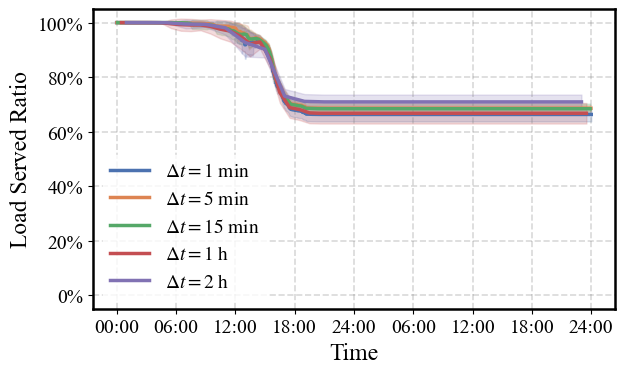

In [16]:
with open("./SolutionFolder/MonteCarlo_Past_Info_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_past_info_sample = pickle.loads(file.read())
    monte_carlo_past_info_sample = [monte_carlo_past_info_sample[m]["all_load_served"] 
                                    for m in range(len(deltaT_list))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)
colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M-1):
    t = np.arange(0, T, deltaT_list[m]) + deltaT_list[m] / 2
    L_total_downsampled = downsample(L_total, deltaT_list[m], 'mean')
    color = colors[m]
    load_served_ratio = monte_carlo_past_info_sample[m] / L_total_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.5),
        label=deltaT_name_list[deltaT_list[m]],
        color=colors[m],
        linewidth=2.5,
    )
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
ax.set_yticks(np.arange(0, 1.01, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'},
                   rotation=0)
plt.ylim(0-0.05, 1.05)
plt.legend(loc='best',
           prop={'family': 'times new roman', 'size': 14},
           edgecolor='1.0',
           framealpha=0.8
)
ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)
plt.tight_layout()
plt.show()

## (d)

Benchmark

In [17]:
monte_carlo_Fatigue_Accumulation_sample = []
for deltaT in deltaT_list:
    deltaT = deltaT_list[0] # A Benchmark is based on the underlying physical mechanisms as the standard answer, using the finest studied resolution.
    L_downsampled = np.zeros((ins.power_traffic_system['bus'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for bus_index in range(ins.power_traffic_system['bus'].shape[0]):
        bus_num = ins.power_traffic_system['bus'][bus_index, BUS_I]
        L_downsampled[bus_index, :] = downsample(ins.power_load_curve[bus_num][:], deltaT, 'mean')
    w_downsampled = np.zeros((ins.power_traffic_system['branch'].shape[0], round(ins.H * (BASE_DELTAT / deltaT))))
    for j in range(ins.power_traffic_system['branch'].shape[0]):
        w_downsampled[j, :] = downsample(w[j][:], deltaT, 'mean')
    monte_carlo_Fatigue_Accumulation_sample.append(MonteCarlo_Fatigue_Accumulation_Sample(
                                        ins, deltaT, N_sim,
                                        L_downsampled, w_downsampled, 
                                        fragility_params={'a': a, 'b': b, 'v0': v0, 'vmax': vmax, 'Dres': Dres}))
    break

Simulation 1/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 2/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2880
  >>>Time step 1600/2880
  >>>Time step 1800/2880
  >>>Time step 2000/2880
  >>>Time step 2200/2880
  >>>Time step 2400/2880
  >>>Time step 2600/2880
  >>>Time step 2800/2880
Simulation 3/100 (deltaT=0.016666666666666666)
  >>>Time step 200/2880
  >>>Time step 400/2880
  >>>Time step 600/2880
  >>>Time step 800/2880
  >>>Time step 1000/2880
  >>>Time step 1200/2880
  >>>Time step 1400/2

In [18]:
f_save = open("./SolutionFolder/MonteCarlo_Fatigue_Accumulation_Sample_Ins.pkl", 'wb')
pickle.dump(monte_carlo_Fatigue_Accumulation_sample, f_save)
f_save.close()

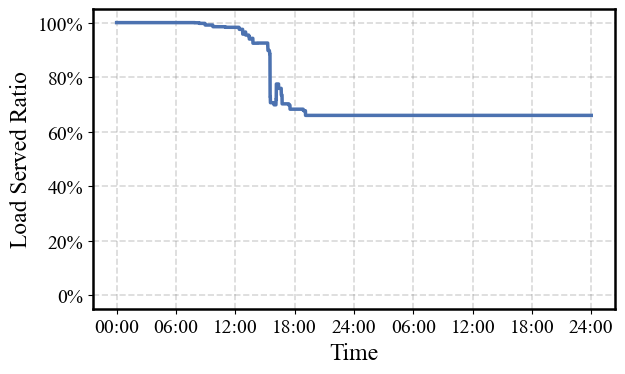

In [19]:
with open("./SolutionFolder/MonteCarlo_Fatigue_Accumulation_Sample_Ins.pkl", 'rb') as file:
    monte_carlo_Fatigue_Accumulation_sample = pickle.loads(file.read())
    monte_carlo_Fatigue_Accumulation_sample = \
        [monte_carlo_Fatigue_Accumulation_sample[m]["all_load_served"] 
         for m in range(len(monte_carlo_Fatigue_Accumulation_sample))]
M = len(deltaT_list)
fig = plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
plt.rc('font', family='Times New Roman', size=15)
colors = sns.color_palette("deep", n_colors=M)
for m in range(0, M):
    deltaT_list_m = deltaT_list[0]
    t = np.arange(0, T, deltaT_list_m) + deltaT_list_m / 2
    L_total_downsampled = downsample(L_total, deltaT_list_m, 'mean')
    color = colors[m]
    load_served_ratio = monte_carlo_Fatigue_Accumulation_sample[m] / L_total_downsampled
    df = {'Load Served Ratio': [], 'Time (hours)': []}
    for i in range(0, N_sim):
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
        df['Load Served Ratio'].extend(load_served_ratio[i])
        df['Time (hours)'].extend(t)
    sns.lineplot(
        data=df,
        x='Time (hours)',
        y='Load Served Ratio',
        errorbar=('sd', 0.5),
        color=colors[m],
        linewidth=2.5,
    )
    break
plt.ylim(0 - 0.05, 1.05)
plt.xlabel('Time', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
plt.ylabel('Load Served Ratio', fontdict={'family': 'times new roman', 'size': 17, 'style': 'normal'})
ax.set_xticks(range(0, T+1, 6))
xticklabels = []
for i in range(0, T+1, 6):
    if i <= 24:
        xticklabels.append(f'{i:02d}:00')
    else:
        xticklabels.append(f'{i-24:02d}:00')
ax.set_xticklabels(xticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'}, # x轴：时间
                   rotation=0)
ax.set_yticks(np.arange(0, 1.01, 0.2))
yticklabels = [f'{i:d}%' for i in np.arange(0, 101, 20)]
ax.set_yticklabels(yticklabels,font={'family': 'times new roman', 'size': 14, 'style': 'normal'}, # y轴：负荷比例
                   rotation=0)
ax.grid(axis='both', color='grey', alpha=0.3, linestyle='--', linewidth=1.2)
ax.spines['bottom'].set_linewidth(1.8)
ax.spines['top'].set_linewidth(1.8)
ax.spines['left'].set_linewidth(1.8)
ax.spines['right'].set_linewidth(1.8)
plt.tight_layout()
plt.show()